$\Huge Code$ $\hspace{0.1cm}$ $\Huge to$ $\hspace{0.1cm}$ $\Huge simulate$ $\hspace{0.1cm}$ $\Huge tSZ$ $\hspace{0.1cm}$ $\Huge maps$ $\hspace{0.1cm}$ $\Huge at$ $\hspace{0.1cm}$ $\Huge differents$ $\hspace{0.1cm}$ $\Huge frequencies$ $\hspace{0.1cm}$ $\Huge from$ $\hspace{0.1cm}$ $\Huge a$ $\hspace{0.1cm}$ $\Huge Compton-y$ $\hspace{0.1cm}$ $\Huge map$ $\Huge :$ 

# Modules : 

In [5]:
%matplotlib inline
import healpy as hp
import matplotlib.pyplot as plt 
from astropy import constants as cst
import numpy as np
from matplotlib import rc
rc('text', usetex=True)
from astropy.io import fits
from astropy import units as u
import pysm as pysm
import ccatp_sky_model as sky
from astropy.cosmology import FlatLambdaCDM

In [6]:
cosmo = FlatLambdaCDM(H0=70, Om0=0.3, Tcmb0=2.7255)
T_CMB = cosmo.Tcmb0.si.value
k_B = cst.k_B.value
h = cst.h.value
c = cst.c.value

In [7]:
data_path = "/vol/arc3/data1/sz/CCATp_sky_model/templates/"

# Functions : 

###### Basics info on tSZ : 

The tSZ spectral shape is given by : 

$\Delta I_{tSZ}=I_{0}yf(x(\nu))h(x(\nu))=I_{0}y\frac{x(\nu)^{4}e ^{x(\nu)}}{(e^{x(\nu)}-1)^{2}}(x(\nu)\frac{e^{x(\nu)}+1}{e^{x(\nu)}-1}-4)$    with $x(\nu)=\frac{h\nu}{k_{B}T_{CMB}}$ and $y=\frac{\sigma _{T}}{m_{e}c^{2}}\int P_{e}dl$ where $P_{e}=n_{e}k_{B}T_{e}$

This allow us to obtain a tSZ map at a given frequency by multiplying the corresponding intensity change or a Compton-y map by diving by it. 

###### Thermal SZ from Simons Observatory simulations :

This map is in units of Compton-y (dimensionless), and was rescaled by a factor (0,75) to bring the amplitude of the power spectrum into reasonable agreement with the Planck 2013 y-map tSZ power spectrum. To get this map in each frequency we need to multiply by the tSZ spectral function and by $T_{CMB}=2,726\times 10^{6}$ to get $\mu K$. 

Here the map we are getting after multiplying by the tSZ spectral function is in MJysr$^{-1}$, we need to convert it in Kelvins first before multiplying it with $T_{CMB}=2,726K$ 

In [8]:
def simulate_tSZ(freq, nside_out = 4096, lmax = None, beam_FWHM = None, template = "SO", unit = "cmb"):
    
    """
    Function which compute tSZ maps at different frequencies and different nside. 
    
    Parameters
    ----------
    freq: float or float array
        Frequency of the output map in Hz.
    nside_out: float
        Healpix nside parameter of the output map. Must be a valid value for nside.
        Default: 4096
    lmax: float
        Maximum value of the multipolemoment at which the atmospheric power spectrum
        wil be computed. Default: 3*nside_out-1            
    beam_FWHM: bool, optional
        If set, the output will be convolved with a gaussian. The FWHM of the Gaussian
        in units of arcmin is given by the provided value. Default: None
    template: bool, optional
        Determines the all-sky foregrounds templates to be used to build the sky model.
        If 'Sehgal' is chosen, simulations by Sehgal et al. (2010) are used.
        If 'SO' is chosen, the Simons Observatory sky model provided by Colin Hill and 
        based on the simulations by Sehgal et al. (2010) is used. If 'CITA' is chosen,
        the used templates will be based on the WebSky Extragalactic CMB Mocks provided 
        by CITA. Default: 'SO'
    unit: bool, optional
        Determines the units of the output map. The available units are 'mjy' --> MJy/sr
        (specific intensity), 'cmb' --> K_CMB (thermodynamic temperature), and 
        'rj' --> K_RJ (brightness temperature). Default: 'cmb'.
        
    Returns
    -------
    tSZ: float array
        Healpix allsky map contaning the tSZ map at a given frequency. 
    """

    #Read data
    if template != "SO" and template != "CITA" and template != "Sehgal":
        print("Waring: Unknown template requested! Output will be based on SO sky model")
        template = "SO"

    if template == 'SO':
        
        file_in ='tSZ/tSZ_skymap_healpix_nopell_Nside4096_y_tSZrescale0p75.fits'
        y_map = hp.read_map(data_path + file_in, dtype = np.float32)

        
    elif template == 'CITA': 
        
        file_in = 'tSZ/tsz.fits'
        y_map = hp.read_map(data_path + file_in, dtype = np.float32)        
        
    elif template == 'Sehgal': 
        
        file_in='tSZ/030_tsz_healpix.fits'
        
        #Create Compton y-map : 
        tSZ_30GHz = hp.read_map(data_path + file_in, dtype = np.float32) * convert_units(30e9, 1e-6, mjy2cmb=True)
           
        x_nu = np.array((h*30e9)/(k_B*T_CMB))    
        tSZ_SED = ((x_nu*(np.exp(x_nu)+1)/(np.exp(x_nu)-1))-4)

        y_map = tSZ_30GHz / tSZ_SED / T_CMB

    #Get tSZ at different frequencies : 
    x_nu = np.array((h*freq)/(k_B*T_CMB))    
    t_SZ_SED = ((x_nu*(np.exp(x_nu)+1)/(np.exp(x_nu)-1))-4)

    tSZ = (y_map * t_SZ_SED * T_CMB)
        
    #Re-bin map if necessary
    if hp.get_nside(tSZ) != nside_out:
        tSZ = hp.pixelfunc.ud_grade(tSZ, nside_out = nside_out)

    #Smooth map if necessary
    if beam_FWHM is not None:
        print("begin smoothing")
        tSZ = hp.sphtfunc.smoothing(tSZ, iter = 0, lmax = lmax, fwhm = beam_FWHM/60*np.pi/180)

    #Convert units if necessary
    if unit == "mjy":
        tSZ = convert_units(freq, tSZ, cmb2mjy=True)
    elif unit == "cmb":
        None
    elif unit == "rj":
        tSZ = convert_units(freq, tSZ, cmb2rj=True)
    else:
        print("Waring: Unknown unit! Output will be in K_CMB")

    return(tSZ)

# Launch and display : 

NSIDE = 4096
ORDERING = RING in fits file
INDXSCHM = IMPLICIT


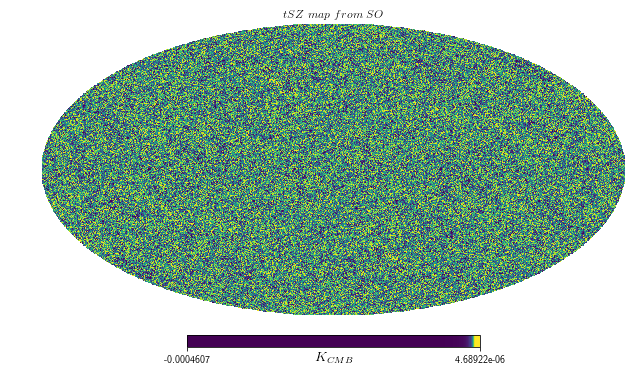

In [10]:
tSZ = simulate_tSZ(freq=30e9, nside_out = 4096, lmax = None, beam_FWHM = None, template = "SO", unit = "cmb")

#Display map The tSZ map : 
hp.mollview(tSZ, title="$tSZ$ $map$ $from$ $SO$", norm='hist',unit='$K_{CMB}$')